# Reproducing Thesis Figures — Organized by Experiment

This notebook reproduces the plots used in the **Experiments** chapter.
It expects a collection of `summary_*.json` logs (one per run) produced by your training script.

### What you get
For each *experiment* (e.g., `mnist-minibatch`), the notebook will generate:
1. **CVFL vs EFVFL under partial participation** (val-acc vs MB, train loss vs epoch).
2. **Scheduler comparison under EFVFL** (Sync, FedBuff, Async, FedSpace).
3. **FedSpace–EFVFL only** results (train loss vs epoch, val-acc vs MB).

### How to use
- Edit **`FILE_PATHS`** to list your JSON summary files; or set **`ROOT_DIRS`** to auto-discover all `summary_*.json` within those directories.
- Set **`OUTPUT_DIR`** to where you want plots saved. Subfolders per experiment will be created.
- Run cells in order. Missing combinations are skipped gracefully.


In [12]:
# %% Imports & style
import json, os, re, warnings
from pathlib import Path
from collections import defaultdict
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams.update({
    "figure.dpi": 110,
    "savefig.bbox": "tight",
})

print("Imports OK")


Imports OK


In [13]:
# %% Configuration

# Option A) Explicit file list (defaults you provided)
FILE_PATHS = [
    "./results/mnist-minibatch-cvfl-0.05k-s0/summary_2025-09-06_11-11-33.json",
    "./results/mnist-minibatch-cvfl-0.05k-s0/summary_2025-09-06_12-35-33.json",
    "./results/mnist-minibatch-cvfl-0.05k-s0/summary_2025-09-07_03-49-27.json",
    "./results/mnist-minibatch-cvfl-0.05k-s0/summary_2025-09-08_17-30-53.json",
    "./results/mnist-minibatch-cvfl-0.05k-s0/summary_2025-09-08_18-16-31.json",
    "./results/mnist-minibatch-cvfl-0.2k-s0/summary_2025-09-06_06-32-34.json",
    "./results/mnist-minibatch-cvfl-0.2k-s0/summary_2025-09-06_07-54-53.json",
    "./results/mnist-minibatch-cvfl-0.2k-s0/summary_2025-09-07_02-31-31.json",
    "./results/mnist-minibatch-cvfl-0.2k-s0/summary_2025-09-08_16-10-41.json",
    "./results/mnist-minibatch-cvfl-0.2k-s0/summary_2025-09-08_16-49-57.json",
    "./results/mnist-minibatch-cvfl-0.5k-s0/summary_2025-09-06_08-51-33.json",
    "./results/mnist-minibatch-cvfl-0.5k-s0/summary_2025-09-06_10-14-11.json",
    "./results/mnist-minibatch-cvfl-0.5k-s0/summary_2025-09-07_03-10-36.json",
    "./results/mnist-minibatch-efvfl-0.05k-s0/summary_2025-09-06_19-34-57.json",
    "./results/mnist-minibatch-efvfl-0.05k-s0/summary_2025-09-06_21-03-35.json",
    "./results/mnist-minibatch-efvfl-0.05k-s0/summary_2025-09-07_05-58-45.json",
    "./results/mnist-minibatch-efvfl-0.05k-s0/summary_2025-09-08_19-26-57.json",
    "./results/mnist-minibatch-efvfl-0.05k-s0/summary_2025-09-08_20-33-19.json",
    "./results/mnist-minibatch-efvfl-0.2k-s0/summary_2025-09-06_14-31-22.json",
    "./results/mnist-minibatch-efvfl-0.2k-s0/summary_2025-09-06_15-59-50.json",
    "./results/mnist-minibatch-efvfl-0.2k-s0/summary_2025-09-07_04-32-23.json",
    "./results/mnist-minibatch-efvfl-0.2k-s0/summary_2025-09-08_19-26-58.json",
    "./results/mnist-minibatch-efvfl-0.2k-s0/summary_2025-09-08_20-33-07.json",
    "./results/mnist-minibatch-efvfl-0.5k-s0/summary_2025-09-06_17-03-30.json",
    "./results/mnist-minibatch-efvfl-0.5k-s0/summary_2025-09-06_18-32-00.json",
    "./results/mnist-minibatch-efvfl-0.5k-s0/summary_2025-09-07_05-15-36.json",
    "./results/mnist-minibatch-svfl-s0/summary_2025-09-06_04-15-05.json",
    "./results/mnist-minibatch-svfl-s0/summary_2025-09-06_05-36-07.json",
    "./results/mnist-minibatch-svfl-s0/summary_2025-09-08_04-13-51.json",
]

# Option B) Or auto-discover within these roots (set to [] to disable)
ROOT_DIRS = []  # e.g., ["./results"]

# If True, keep CLI-like flag for compatibility
INCLUDE_BASELINE = False

# Discovery (if ROOT_DIRS set)
if ROOT_DIRS:
    discovered = []
    for rd in ROOT_DIRS:
        discovered.extend(str(p) for p in Path(rd).rglob("summary_*.json"))
    FILE_PATHS = sorted(set(FILE_PATHS + discovered))

# Filter to existing files; warn about missing
existing_paths = [p for p in FILE_PATHS if Path(p).exists()]
missing = sorted(set(FILE_PATHS) - set(existing_paths))
if missing:
    warnings.warn(f"{len(missing)} files not found; proceeding with {len(existing_paths)} existing.")
print(f"Using {len(existing_paths)} JSON files")

Using 23 JSON files


/tmp/ipykernel_63549/2972517935.py:53: UserWarning: 6 files not found; proceeding with 23 existing.
  warnings.warn(f"{len(missing)} files not found; proceeding with {len(existing_paths)} existing.")


In [14]:
# %% Helpers & parsing (ported)

COMPRESSOR_COLOR_MAP = {None: 'blue', 'direct': 'orange', 'ef': 'green'}
COMPRESSOR_MARKER_MAP = {None: 's', 'direct': 'o', 'ef': '^'}
COMPRESSOR_METHOD_MAP = {None: 'SVFL', 'direct': 'CVFL', 'ef': 'EF-VFL'}

SCHED_COLOR_MAP = {
    "fedspace": "tab:blue",
    "sync": "tab:orange",
    "async": "tab:purple",
    "fedbuff": "tab:red",
}
SCHED_MARKER_MAP = {
    "fedspace": "o",
    "sync": "s",
    "async": "^",
    "fedbuff": "D",
}

METRICS_MAP = {
    "epoch": "Epoch",
    "comm_cost": "Communications (MB)",
    "grad_squared_norm": "Train gradient squared norm",
    "val_acc": "Validation accuracy",
    "train_loss": "Train loss",
    "val_loss": "Validation loss",
}
SCHED_LABELS = {"fedspace": "fedspace", "sync": "sync", "async": "async", "fedbuff": "fedbuff"}

RUN_NAME_RE = re.compile(
    r"(?P<experiment>[^/\\]+)-(?:(?P<method>svfl)|(?P<method2>cvfl|efvfl))(?:-(?P<compressor>[\d.]+k))?-s(?P<seed>\d+)"
)
TS_RE = re.compile(r"summary_(?P<date>\d{4}-\d{2}-\d{2})_(?P<h>\d{2})-(?P<m>\d{2})-(?P<s>\d{2})\.json$")

def parse_timestamp_from_path(path: str):
    m = TS_RE.search(Path(path).name)
    if not m:
        return None
    datestr = m.group("date") + f" {m.group('h')}:{m.group('m')}:{m.group('s')}"
    try:
        return datetime.strptime(datestr, "%Y-%m-%d %H:%M:%S")
    except Exception:
        return None

def infer_run_id_from_path(path: str):
    folder = Path(path).parent.name
    m = RUN_NAME_RE.match(folder)
    if not m:
        return {
            "experiment": "unknown",
            "method": None,
            "compression_type": None,
            "compressor": None,
            "seed": "0",
            "base_name": folder
        }

    method = m.group("method") or m.group("method2")
    if method == "svfl":
        compression_type = None
    elif method == "cvfl":
        compression_type = "direct"
    elif method == "efvfl":
        compression_type = "ef"
    else:
        compression_type = None

    compressor = m.group("compressor")
    seed = m.group("seed")
    experiment = m.group("experiment")
    base_name = f"{experiment}-{method}{('-' + compressor) if compressor and method!='svfl' else ''}-s{seed}"

    return {
        "experiment": experiment,
        "method": method,
        "compression_type": compression_type,
        "compressor": compressor,
        "seed": seed,
        "base_name": base_name
    }

def _detect_schedule(cfg):
    """Return canonical schedule key; async is the default/no-scheduler."""
    agg_mode = (cfg.get("agg_mode", "") or "").lower()
    if agg_mode in ("sync", "fedbuff", "fedspace", "async"):
        return "async" if agg_mode == "async" else agg_mode

    try:
        sched = (cfg["model"]["params"].get("scheduler", "") or "").lower()
        if sched == "fedspace":
            return "fedspace"
    except Exception:
        pass

    # Default: async (no scheduler)
    return "async"



def read_json_history(path: str):
    with open(path, "r") as f:
        data = json.load(f)
    cfg = data.get("config", {})
    hist = data.get("history", {})

    compression_type = None
    try:
        compression_type = cfg["model"]["params"].get("compression_type", None)
        if compression_type in (None, "none", "svfl"):
            compression_type = None
        elif compression_type in ("direct", "cvfl"):
            compression_type = "direct"
        elif compression_type in ("ef", "efvfl"):
            compression_type = "ef"
    except Exception:
        pass

    schedule = _detect_schedule(cfg)

    try:
        max_epochs = int(cfg["trainer"].get("max_epochs", 0))
    except Exception:
        max_epochs = 0
    if max_epochs <= 0:
        participation = "other"
    elif max_epochs <= 20:
        participation = "full"
    elif max_epochs >= 100:
        participation = "partial"
    else:
        participation = "other"

    return cfg, hist, compression_type, data.get("has_baseline", False), schedule, participation

def build_epoch_array(history_dict):
    for key in ["val_acc", "train_loss", "val_loss", "train_acc", "comm_cost"]:
        arr = history_dict.get(key)
        if isinstance(arr, list) and len(arr) > 0:
            n = len(arr)
            return np.arange(1, n + 1, dtype=int)
    return np.array([], dtype=int)

def align_to_min_length(list_of_arrays):
    min_len = min(len(a) for a in list_of_arrays if a is not None)
    return [np.array(a[:min_len]) for a in list_of_arrays]

def maybe_log10(y_metric, values):
    if y_metric in ["grad_squared_norm", "train_loss", "val_loss"]:
        return np.log10(values)
    return values

def compute_markevery(x):
    if len(x) <= 20:
        return 1
    return max(2, len(x)//8)

def plot_mean_only(x_values, y_values_list, y_metric, color, method_name, marker, ax=None):
    ax = ax or plt.gca()
    y_values_array = np.vstack(y_values_list)
    y_values_array = maybe_log10(y_metric, y_values_array)
    y_mean = np.mean(y_values_array, axis=0)
    me = compute_markevery(x_values)
    ax.plot(x_values, y_mean, label=method_name, marker=marker,
            markersize=8, markevery=me, linewidth=2, color=color)
    return y_mean

def get_xy_from_histories(entry, x_metric, y_metric):
    x_list = entry["x_epoch"] if x_metric == "epoch" else entry["x_comm"]
    if x_list is None:
        return None, None
    min_len = min(len(x) for x in x_list)
    x_values = x_list[0][:min_len].astype(float)

    y_values_list = []
    for hist in entry["y_histories"]:
        series = hist.get(y_metric)
        if not isinstance(series, list) or len(series) < min_len:
            return None, None
        y_values_list.append(np.array(series[:min_len], dtype=float))
    return x_values, y_values_list


In [15]:
# %% Aggregation and plotting

def aggregate(paths, include_baseline=False):
    records = []
    for p in paths:
        try:
            inferred = infer_run_id_from_path(p)
            cfg, hist, comp_from_cfg, has_base, schedule, participation = read_json_history(p)
            ctype = comp_from_cfg if comp_from_cfg is not None else inferred.get("compression_type", None)
            records.append({
                "cfg": cfg, "hist": hist, "ctype": ctype, "has_base": has_base,
                "inferred": inferred, "schedule": schedule, "participation": participation, "path": p,
            })
        except Exception as e:
            warnings.warn(f"Failed to load {p}: {e}")

    bundle_map = defaultdict(list)
    for r in records:
        inf = r["inferred"]
        key = (inf["base_name"], r["schedule"], r["participation"])
        bundle_map[key].append((r["cfg"], r["hist"], r["ctype"], r["has_base"], r["inferred"]))

    groups = defaultdict(lambda: {"methods": defaultdict(list)})
    metrics_available = defaultdict(set)

    for (base_name, schedule, participation), repeats in bundle_map.items():
        _, _, comp_type, _, inferred = repeats[-1]
        exp = inferred["experiment"]
        compressor = inferred.get("compressor", None) if inferred.get("method") != "svfl" else None

        x_epoch_list, x_comm_list, y_histories_per_repeat = [], [], []
        for (cfg, hist, _, has_base, _inf) in repeats:
            def keep_all(a):
                if not isinstance(a, list): return None
                if len(a) == 0: return None
                return a
            hist_kept = {k: keep_all(v) for k, v in hist.items()}
            epoch_arr = build_epoch_array(hist_kept)
            x_epoch_list.append(np.array(epoch_arr, dtype=int))
            comm_arr = hist_kept.get("comm_cost")
            x_comm_list.append(np.array(comm_arr, dtype=float) if comm_arr is not None else None)
            y_histories_per_repeat.append(hist_kept)

        x_epoch_list = align_to_min_length([x for x in x_epoch_list if x is not None])
        x_comm_present = [x for x in x_comm_list if x is not None]
        x_comm_list = align_to_min_length(x_comm_present) if len(x_comm_present) > 0 else None

        groups[(exp, compressor, schedule, participation)]["methods"][comp_type].append({
            "x_epoch": x_epoch_list,
            "x_comm": x_comm_list,
            "y_histories": y_histories_per_repeat
        })

        for (_, hist, _, _, _) in repeats:
            for k, v in hist.items():
                if isinstance(v, list) and len(v) > 0:
                    metrics_available[(exp, compressor, schedule, participation)].add(k)

    return groups, metrics_available

def _epoch_max_from_methods(methods, y_metric):
    nmax = 0
    for entries in methods.values():
        for entry in entries:
            for hist in entry["y_histories"]:
                series = hist.get(y_metric)
                if isinstance(series, list):
                    nmax = max(nmax, len(series))
    return nmax

def _epoch_max_from_schedmap(schedule_entries_map, y_metric):
    nmax = 0
    for entries in schedule_entries_map.values():
        for entry in entries:
            for hist in entry["y_histories"]:
                series = hist.get(y_metric)
                if isinstance(series, list):
                    nmax = max(nmax, len(series))
    return nmax

def _plot_bucket(methods, x_metric, y_metric, ax=None):
    ax = ax or plt.gca()
    xs_for_bounds, ys_for_bounds, made_any_curve = [], [], False
    for comp_type in [None, 'direct', 'ef']:
        if comp_type not in methods:
            continue
        y_values_agg, x_values_ref = [], None
        for entry in methods[comp_type]:
            x_values, y_values_list = get_xy_from_histories(entry, x_metric, y_metric)
            if x_values is None or y_values_list is None:
                continue
            y_values_agg.extend(y_values_list)
            if x_values_ref is None:
                x_values_ref = x_values
        if x_values_ref is None or not y_values_agg:
            continue
        color  = COMPRESSOR_COLOR_MAP[comp_type]
        marker = COMPRESSOR_MARKER_MAP[comp_type]
        label  = COMPRESSOR_METHOD_MAP[comp_type]
        y_mean = plot_mean_only(x_values_ref, y_values_agg, y_metric, color, label, marker, ax=ax)
        xs_for_bounds.append(x_values_ref); ys_for_bounds.append(y_mean); made_any_curve = True

    if not made_any_curve:
        return None

    if x_metric == "comm_cost":
        x_min = 0.0
        x_max = max(float(np.max(x)) for x in xs_for_bounds if len(x) > 0)
        x_span = max(1e-9, x_max - x_min)
        x_left, x_right = x_min, x_max + 0.02 * x_span
    else:
        N = _epoch_max_from_methods(methods, y_metric)
        if N <= 0:
            N = int(max(float(np.max(x)) for x in xs_for_bounds if len(x) > 0))
        x_left, x_right = 1, int(N)

    y_min = min(float(np.min(y)) for y in ys_for_bounds if len(y) > 0)
    y_max = max(float(np.max(y)) for y in ys_for_bounds if len(y) > 0)
    y_pad = 0.07 * (y_max - y_min) if y_min != y_max else max(0.1, abs(y_max) * 0.1)
    y_bottom, y_top = y_min - y_pad, y_max + y_pad
    return x_left, x_right, y_bottom, y_top

def _plot_schedulers_bucket(schedule_entries_map, x_metric, y_metric, ax=None, label_overrides=None):
    ax = ax or plt.gca()
    xs_for_bounds, ys_for_bounds, made_any_curve = [], [], False
    sched_order = ["fedspace", "sync", "fedbuff", "async"]

    for sched in sched_order:
        entries = schedule_entries_map.get(sched, [])
        if not entries:
            continue
        y_values_agg, x_values_ref = [], None
        for entry in entries:
            x_values, y_values_list = get_xy_from_histories(entry, x_metric, y_metric)
            if x_values is None or y_values_list is None:
                continue
            y_values_agg.extend(y_values_list)
            if x_values_ref is None:
                x_values_ref = x_values
        if x_values_ref is None or len(y_values_agg) == 0:
            continue

        color  = SCHED_COLOR_MAP.get(sched, "black")
        marker = SCHED_MARKER_MAP.get(sched, "o")
        label = (label_overrides.get(sched) if label_overrides else None) or SCHED_LABELS.get(sched, sched)
        y_mean = plot_mean_only(x_values_ref, y_values_agg, y_metric, color, label, marker, ax=ax)

        xs_for_bounds.append(x_values_ref); ys_for_bounds.append(y_mean); made_any_curve = True

    if not made_any_curve:
        return None

    if x_metric == "comm_cost":
        x_min = 0.0
        x_max = max(float(np.max(x)) for x in xs_for_bounds if len(x) > 0)
        x_span = max(1e-9, x_max - x_min)
        x_left, x_right = x_min, x_max + 0.02 * x_span
    else:
        N = _epoch_max_from_schedmap(schedule_entries_map, y_metric)
        if N <= 0:
            N = int(max(float(np.max(x)) for x in xs_for_bounds if len(x) > 0))
        x_left, x_right = 1, int(N)

    y_min = min(float(np.min(y)) for y in ys_for_bounds if len(y) > 0)
    y_max = max(float(np.max(y)) for y in ys_for_bounds if len(y) > 0)
    y_pad = (0.07 * (y_max - y_min)) if (y_min != y_max) else max(0.1, abs(y_max) * 0.1)
    y_bottom, y_top = y_min - y_pad, y_max + y_pad
    return x_left, x_right, y_bottom, y_top

def _smart_schedcmp_comm_cap(schedule_map, frac=1.03):
    keep = ("fedspace", "sync", "async")
    xmax = 0.0
    for sched in keep:
        for entry in schedule_map.get(sched, []):
            x_list = entry.get("x_comm")
            if not x_list:
                continue
            try:
                xmax = max(xmax, float(np.max(x_list[0])))
            except Exception:
                pass
    return (xmax * frac) if xmax > 0 else None

def comm_xmax_for(compressor: str, schedule_key: str):
    table = {
        ('0.2k',  'fedspace'): 1000.0,
        ('0.2k',  'async'):    2000.0,
        ('0.5k',  'fedspace'): 2000.0,
        ('0.5k',  'async'):    4500.0,
        ('0.05k', 'fedspace'): 500.0,
        ('0.05k', 'async'):    500.0,
    }
    return table.get((compressor, schedule_key), None)

def _ensure_outdirs(base_dir):
    base = Path(base_dir)
    pdf_dir = base / "pdf"
    img_dir = base / "images"
    pdf_dir.mkdir(parents=True, exist_ok=True)
    img_dir.mkdir(parents=True, exist_ok=True)
    return pdf_dir, img_dir


In [16]:
# Build the groups structure from your summaries
groups, metrics_available = aggregate(existing_paths, include_baseline=INCLUDE_BASELINE)
print("Ready. Keys found:", len(groups))


Ready. Keys found: 13


In [17]:
def show_plot(title_stub, x_metric, y_metric,
              x_left, x_right, y_bottom, y_top,
              forced_comm_xmax: float = None):
    ax = plt.gca()

    # X axis
    if x_metric == "comm_cost" and forced_comm_xmax is not None:
        ax.set_xlim(0.0, float(forced_comm_xmax))
    else:
        ax.set_xlim(x_left, x_right)

    # Epoch ticks
    if x_metric == "epoch":
        _, prev_right = ax.get_xlim()
        N = int(round(prev_right))
        ax.set_xlim(0, N + 1)
        total_right = N + 1
        step = 1 if total_right <= 21 else (5 if total_right <= 61 else 10)
        ax.set_xticks(np.arange(0, total_right + 1, step))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Y axis formatting
    if y_metric in ["train_loss", "val_loss"]:
        ax.set_ylim(y_bottom, y_top)
        ax.yaxis.set_major_formatter(StrMethodFormatter(r'$10^{{{x:.1f}}}$'))
    elif y_metric == "val_acc":
        ax.set_ylim(0.0, 1.0)
        ax.set_yticks(np.arange(0.0, 1.0 + 1e-9, 0.2))
    else:
        ax.set_ylim(y_bottom, y_top)

    # Labels, legend, grid
    plt.xlabel(METRICS_MAP.get(x_metric, x_metric), fontsize=16)
    plt.ylabel(METRICS_MAP.get(y_metric, y_metric), fontsize=16)
    plt.title(title_stub, fontsize=14)
    plt.legend(loc='best', fontsize=12, framealpha=0.9)
    plt.grid(True, alpha=0.35)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()

In [18]:
# %% Plotting (show-only) drivers for specific figures

def _plot_bucket_show(methods, title_stub, x_metric, y_metric, forced_comm_xmax=None):
    plt.figure(figsize=(7, 5))
    bounds = _plot_bucket(methods, x_metric=x_metric, y_metric=y_metric)
    if bounds is None:
        plt.close()
        print("Nothing to plot for:", title_stub, x_metric, y_metric)
        return
    x_left, x_right, y_bottom, y_top = bounds
    show_plot(title_stub, x_metric, y_metric, x_left, x_right, y_bottom, y_top, forced_comm_xmax)

def _plot_sched_bucket_show(schedule_entries_map, title_stub, x_metric, y_metric,
                            label_overrides=None, forced_comm_xmax=None):
    plt.figure(figsize=(7, 5))
    bounds = _plot_schedulers_bucket(schedule_entries_map, x_metric=x_metric, y_metric=y_metric,
                                     ax=plt.gca(), label_overrides=label_overrides)
    if bounds is None:
        plt.close()
        print("Nothing to plot for:", title_stub, x_metric, y_metric)
        return
    x_left, x_right, y_bottom, y_top = bounds
    show_plot(title_stub, x_metric, y_metric, x_left, x_right, y_bottom, y_top, forced_comm_xmax)

def _collect_methods(groups, experiment, compressor, schedule, participation="partial"):
    key = (experiment, compressor, schedule, participation)
    if key not in groups:
        return None
    payload = groups[key]
    methods = dict(payload["methods"])

    # Try to add SVFL from same (experiment, schedule) if missing (as in your CLI script)
    if None not in methods:
        # search for SVFL cache as in previous logic
        for (exp2, comp2, sched2, part2), pay2 in groups.items():
            if exp2 == experiment and sched2 == schedule and part2 == participation and comp2 is None and None in pay2["methods"]:
                methods[None] = pay2["methods"][None]
                break
    return methods

def show_baseline(experiment="mnist-minibatch", compressor="0.2k", schedule=None):
    """
    Baseline panels (SVFL, CVFL, EFVFL if available) for a single schedule.
    Defaults to 'async' when not specified.
    """
    chosen_sched = schedule
    if chosen_sched is None:
        candidates = []
        for (exp, comp, sched, part) in groups.keys():
            if exp == experiment and comp == compressor and part == "partial":
                candidates.append(sched)
        if "async" in candidates:
            chosen_sched = "async"
        elif candidates:
            chosen_sched = sorted(set(candidates))[0]

    if chosen_sched is None:
        print(f"No groups for {experiment} {compressor} (partial) at any schedule.")
        return

    methods = _collect_methods(groups, experiment, compressor, chosen_sched, participation="partial")
    if not methods:
        print(f"No data for baseline: {experiment} {compressor} {chosen_sched}")
        return

    stub = f"{experiment}-{compressor}-{SCHED_LABELS.get(chosen_sched, chosen_sched)}-partial"

    forced_x = comm_xmax_for(compressor, chosen_sched)
    _plot_bucket_show(methods, f"{stub} — Validation accuracy vs MB",
                      x_metric="comm_cost", y_metric="val_acc", forced_comm_xmax=forced_x)
    _plot_bucket_show(methods, f"{stub} — Train loss vs Epoch",
                      x_metric="epoch", y_metric="train_loss")



def show_schedcmp_efvfl(experiment="mnist-minibatch", compressor="0.2k"):
    """
    Reproduces scheduler-comparison panels under EFVFL:
      - Train loss per epoch
      - Val accuracy per MB
    Filenames in paper:
      mnist-minibatch-0.2k-efvfl-SCHEDCMP-partial_...
    """
    # Gather EF-only entries by schedule for partial participation
    combos = defaultdict(list)
    for (exp, comp, sched, part), payload in groups.items():
        if exp == experiment and comp == compressor and part == "partial":
            ef_entries = payload["methods"].get("ef", [])
            if ef_entries:
                combos[sched].extend(ef_entries)

    if not combos:
        print("No EFVFL data for scheduler comparison:", experiment, compressor)
        return

    KEEP = ("fedspace", "sync", "fedbuff", "async")
    LABEL_OVERRIDES = None

    # ACC vs MB
    schedule_map_val = {s: combos[s] for s in KEEP if s in combos}
    cap = _smart_schedcmp_comm_cap({k: schedule_map_val[k] for k in ("fedspace", "sync", "async") if k in schedule_map_val}, frac=1.03)
    _plot_sched_bucket_show(schedule_map_val,
                            f"{experiment}-{compressor}-efvfl — sched cmp: Accuracy vs MB",
                            x_metric="comm_cost", y_metric="val_acc",
                            label_overrides=LABEL_OVERRIDES, forced_comm_xmax=cap)

    # TRAIN LOSS vs EPOCH
    schedule_map_epoch = {s: combos[s] for s in KEEP if s in combos}
    _plot_sched_bucket_show(schedule_map_epoch,
                            f"{experiment}-{compressor}-efvfl — sched cmp: Train loss vs Epoch",
                            x_metric="epoch", y_metric="train_loss",
                            label_overrides=LABEL_OVERRIDES)

def show_fedspace_efvfl(experiment="mnist-minibatch", compressor="0.2k"):
    """
    Reproduces FedSpace-only EFVFL panels:
      - Train loss vs epoch
      - Val accuracy vs MB
    Filenames in paper:
      mnist-minibatch-0.2k-fedspace-partial_...
    """
    key = (experiment, compressor, "fedspace", "partial")
    if key not in groups:
        print("No FedSpace EFVFL group:", key)
        return
    payload = groups[key]
    
    methods = {"ef": payload["methods"].get("ef", [])}
    if not methods["ef"]:
        print("No EFVFL entries under FedSpace for:", key)
        return

    stub = f"{experiment}-{compressor}-fedspace-partial"
    _plot_bucket_show(methods, f"{stub} — Train loss vs Epoch", x_metric="epoch", y_metric="train_loss")
    forced_x = comm_xmax_for(compressor, "fedspace")
    _plot_bucket_show(methods, f"{stub} — Validation accuracy vs MB", x_metric="comm_cost", y_metric="val_acc",
                      forced_comm_xmax=forced_x)


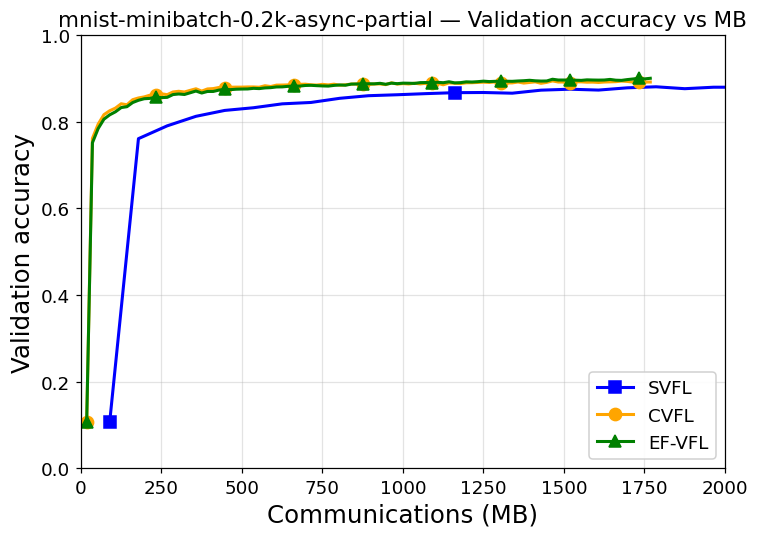

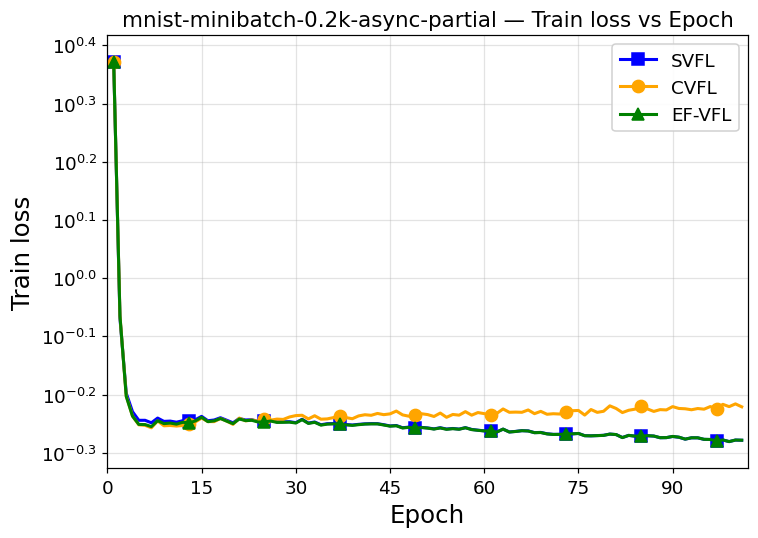

In [19]:
show_baseline(experiment="mnist-minibatch", compressor="0.2k")

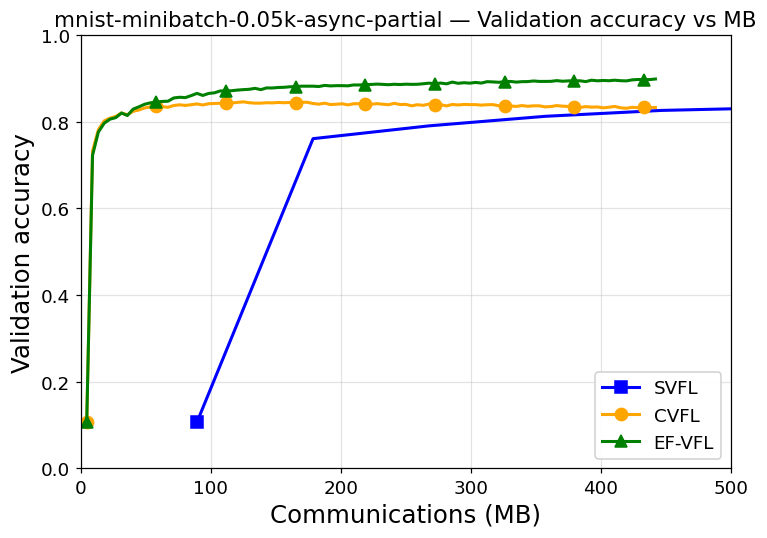

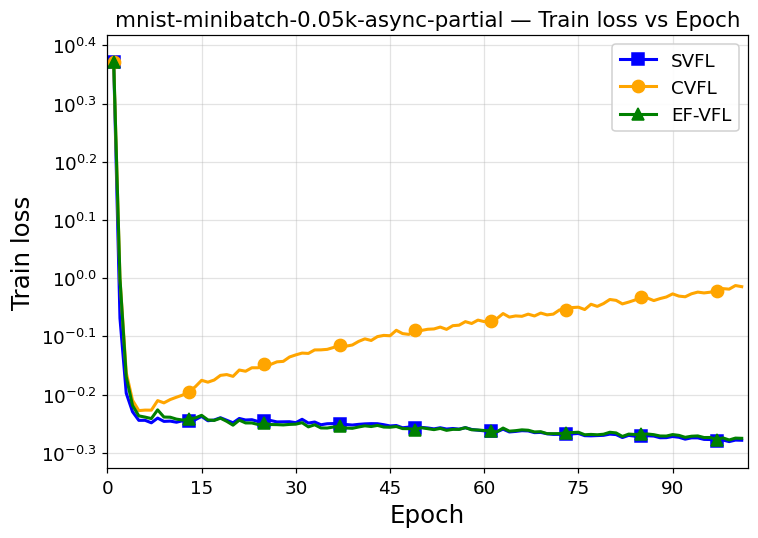

In [20]:
show_baseline(experiment="mnist-minibatch", compressor="0.05k")

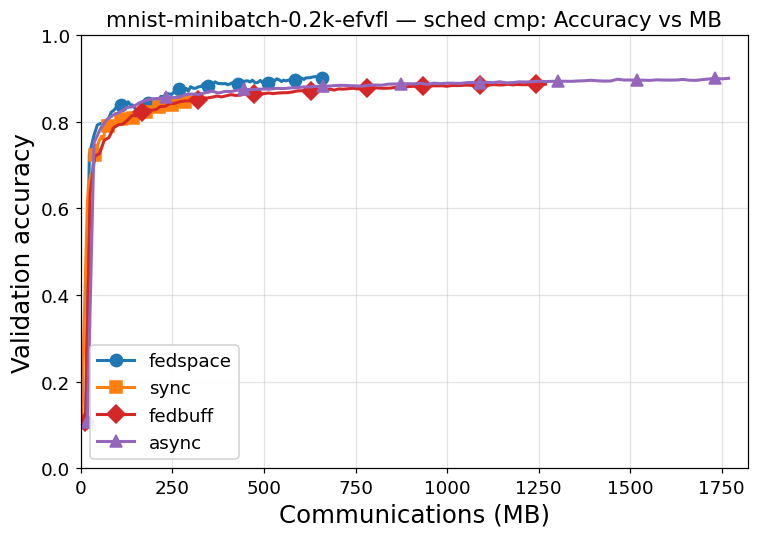

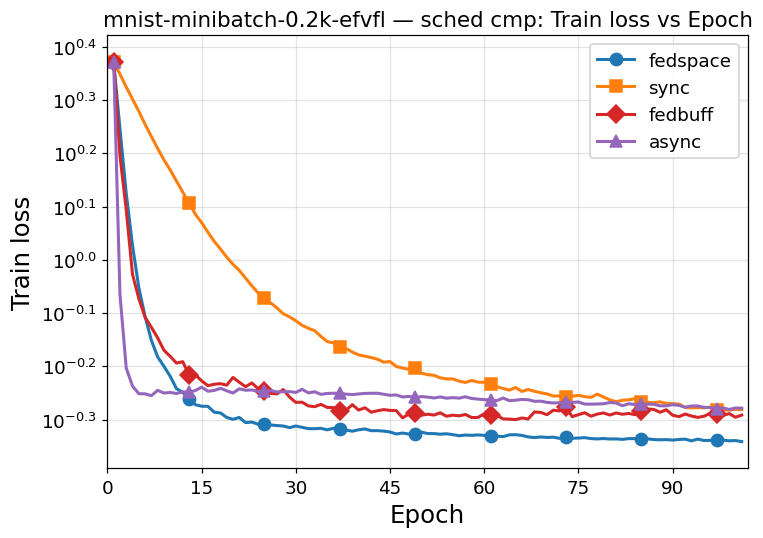

In [21]:
show_schedcmp_efvfl(experiment="mnist-minibatch", compressor="0.2k")

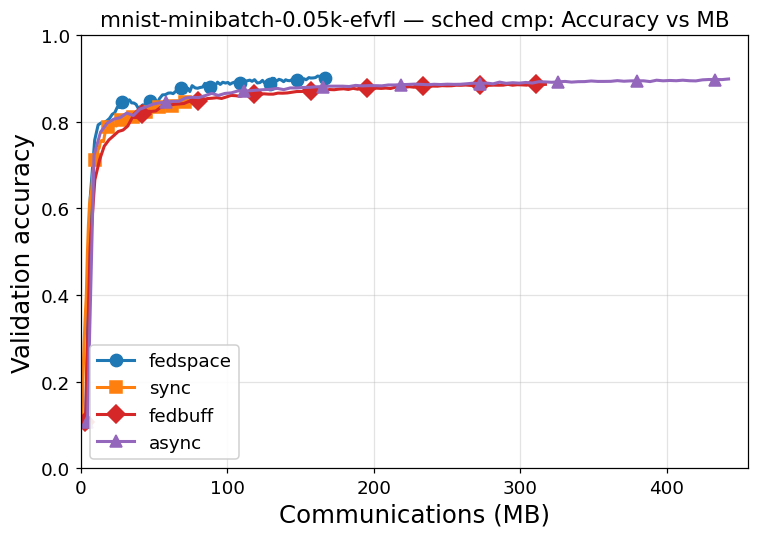

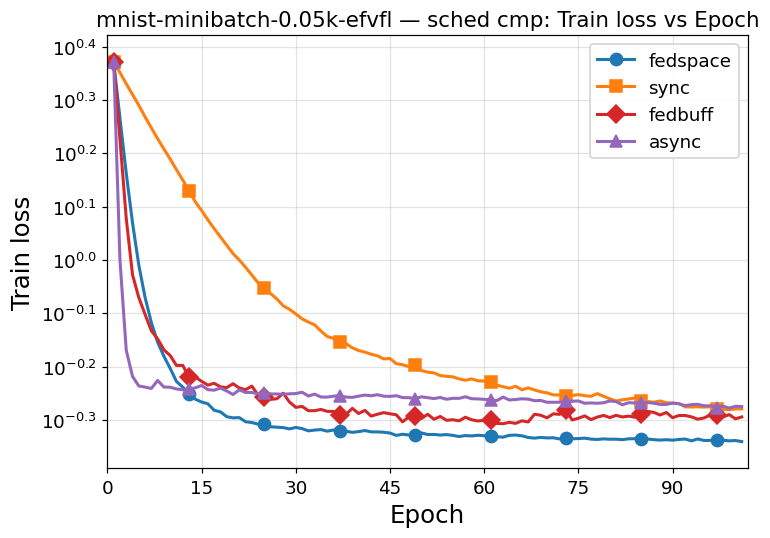

In [22]:
show_schedcmp_efvfl(experiment="mnist-minibatch", compressor="0.05k")